In [13]:
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio
import rasterio.mask

Index(['OBJECTID', 'TAZID', 'AREA', 'X', 'Y', 'ZONE', 'LENG_ROAD',
       'SHAPE_Leng', 'SHAPE_Area', 'geometry'],
      dtype='object')
(491, 10)


<Axes: >

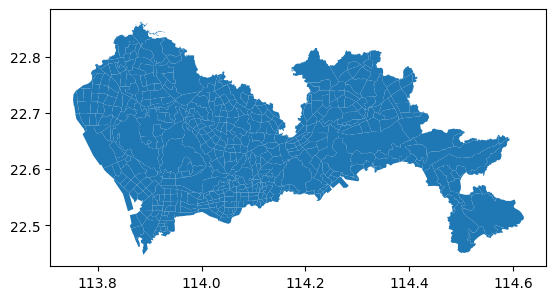

In [22]:
shenzhen = gpd.read_file("/gpfsnyu/home/yw9871/New data/Shenzhen/Shenzhen.shp") 
shenzhen = shenzhen.set_crs(epsg=3857)
shenzhen = shenzhen.to_crs(epsg=4326)
print(shenzhen.columns)
print(shenzhen.shape)
shenzhen.plot()

In [86]:
def china_tif_to_shenzhen_csv_by_district(
    tif_path,
    shenzhen_path):
    # 读取深圳边界
    shp = gpd.read_file(shenzhen_path)
    shp = shp.set_crs(epsg=3857)
    
    # 检查可用的字段名
    print("可用的字段名:", list(shp.columns))
    
    results = []
    
    with rasterio.open(tif_path) as src:
        shp = shp.to_crs(src.crs)
        
        # 对每个区（polygon）分别处理
        for idx, district in shp.iterrows():
            try:
                # 获取当前区的几何形状
                geometry = [district.geometry]
                
                # 裁剪当前区
                out_image, out_transform = rasterio.mask.mask(
                    src, geometry, crop=True, all_touched=True
                )
                data = out_image[0]
                
                # 过滤 nodata 值
                valid_mask = (data != src.nodata)
                valid_values = data[valid_mask]
                
                # 计算当前区的人口总数
                district_population = np.sum(valid_values)
                
                # 统计像元数量
                pixel_count = np.sum(valid_mask)
                
                results.append({
                    'TAZID': district['TAZID'],
                    'population': district_population,
                    #'pixel_count': pixel_count,
                    'geometry': district.geometry
                })
                
            except Exception as e:
                print(f"处理区域 {idx} 时出错: {e}")
                continue
    
    # 4. 创建结果DataFrame
    result_df = pd.DataFrame(results)
    
    # 5. 保存为 CSV（不包含geometry列）
    #csv_df = result_df.drop('geometry', axis=1)
    #csv_df.to_csv(output_csv, index=False)
    
    # 6. 创建包含地理信息的GeoDataFrame
    gdf = gpd.GeoDataFrame(result_df, geometry='geometry', crs=src.crs)
    gdf['TAZID'] = gdf['TAZID'].astype(int)
    gdf['population'] = gdf['population'].astype(int)
    gdf_area = gdf.to_crs('EPSG:6933')
    gdf['area'] = gdf_area.geometry.area / 1000000
    gdf['density'] = gdf['population'] / gdf['area'] # 人/平方公里
    
    # 可选：保存为shapefile
    #gdf.to_file("shenzhen_population_by_district.shp")
    
    print(f"处理区域数量: {len(result_df)}")
    print(f"总人口: {result_df['population'].sum():.0f}")
    
    return gdf

In [92]:
gdf_shenzhen_2022 = china_tif_to_shenzhen_csv_by_district(
    tif_path="chn_pop_2022_CN_1km_R2025A_UA_v1.tif",
    shenzhen_path='/gpfsnyu/home/yw9871/New data/Shenzhen/Shenzhen.shp')
gdf_shenzhen_2022.head(2)

可用的字段名: ['OBJECTID', 'TAZID', 'AREA', 'X', 'Y', 'ZONE', 'LENG_ROAD', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']
处理区域数量: 491
总人口: 51964624


,TAZID,population,geometry,area,density
0,1054,110782,"POLYGON ((114.33501 22.81134, 114.33611 22.810...",11.490872,9640.870093
1,1052,64528,"POLYGON ((114.28016 22.81017, 114.28035 22.808...",17.081751,3777.598622


In [91]:
gdf_shenzhen_2022.to_file("shenzhen_population_by_district_2022.geojson", driver='GeoJSON')

In [93]:
gdf_shenzhen_2023 = china_tif_to_shenzhen_csv_by_district(
    tif_path="chn_pop_2023_CN_1km_R2025A_UA_v1.tif",
    shenzhen_path='/gpfsnyu/home/yw9871/New data/Shenzhen/Shenzhen.shp')
gdf_shenzhen_2023.head(2)

可用的字段名: ['OBJECTID', 'TAZID', 'AREA', 'X', 'Y', 'ZONE', 'LENG_ROAD', 'SHAPE_Leng', 'SHAPE_Area', 'geometry']
处理区域数量: 491
总人口: 51898800


,TAZID,population,geometry,area,density
0,1054,110617,"POLYGON ((114.33501 22.81134, 114.33611 22.810...",11.490872,9626.510869
1,1052,64436,"POLYGON ((114.28016 22.81017, 114.28035 22.808...",17.081751,3772.212758


In [94]:
gdf_shenzhen_2023.to_file("shenzhen_population_by_district_2023.geojson", driver='GeoJSON')